In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from torch.optim import AdamW
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

2026-01-20 06:24:41.848641: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768890282.057922      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768890282.119186      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768890282.577165      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768890282.577220      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768890282.577224      55 computation_placer.cc:177] computation placer alr

In [4]:
# Set style for plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("="*80)
print("EMOTION CLASSIFICATION WITH DISTILBERT")
print("="*80)

EMOTION CLASSIFICATION WITH DISTILBERT


In [5]:
# =====================================================================
# 1. LOAD AND EXPLORE DATA
# =====================================================================
print("\n[1] Loading Dataset...")
df = pd.read_csv('/kaggle/input/emotion-emotional/emotion-emotion_69k.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nFirst few rows:")
print(df.head())

print(f"\nDataset Info:")
print(df.info())

print(f"\nMissing values:")
print(df.isnull().sum())



[1] Loading Dataset...
Dataset shape: (64636, 7)

First few rows:
   Unnamed: 0                                          Situation      emotion  \
0           0  I remember going to the fireworks with my best...  sentimental   
1           1  I remember going to the fireworks with my best...  sentimental   
2           2  I remember going to the fireworks with my best...  sentimental   
3           3  I remember going to the fireworks with my best...  sentimental   
4           4  I remember going to the fireworks with my best...  sentimental   

                                empathetic_dialogues  \
0  Customer :I remember going to see the firework...   
1  Customer :This was a best friend. I miss her.\...   
2              Customer :We no longer talk.\nAgent :   
3  Customer :Was this a friend you were in love w...   
4             Customer :Where has she gone?\nAgent :   

                                              labels Unnamed: 5 Unnamed: 6  
0  Was this a friend you were in

In [6]:
# Check emotion distribution
print(f"\nEmotion distribution:")
print(df['emotion'].value_counts())


Emotion distribution:
emotion
surprised                                                                                                                                                                                         3295
excited                                                                                                                                                                                           2465
angry                                                                                                                                                                                             2296
proud                                                                                                                                                                                             2247
annoyed                                                                                                                                                                      

In [7]:
valid_emotions = [
    'surprised','excited','angry','proud','annoyed','sad','lonely','afraid','grateful',
    'terrified','guilty','furious','disgusted','confident','anxious','anticipating',
    'hopeful','impressed','nostalgic','disappointed','jealous','joyful','prepared',
    'content','devastated','embarrassed','sentimental','caring','trusting','ashamed',
    'apprehensive','faithful'
]

df = df[df['emotion'].isin(valid_emotions)]


In [8]:
# =====================================================================
# 2. DATA PREPROCESSING
# =====================================================================
print("\n[2] Preprocessing Data...")

# Drop rows with missing values in key columns
df_clean = df.dropna(subset=['Situation', 'emotion', 'empathetic_dialogues'])

# Combine text features for better context
df_clean['combined_text'] = (
    "Situation: " + df_clean['Situation'].astype(str) + 
    " [SEP] Dialogue: " + df_clean['empathetic_dialogues'].astype(str) + 
    " [SEP] Response: " + df_clean['labels'].astype(str)
)


# Encode labels
label_encoder = LabelEncoder()
df_clean['emotion_encoded'] = label_encoder.fit_transform(df_clean['emotion'])

print(f"Cleaned dataset shape: {df_clean.shape}")
print(f"Number of unique emotions: {df_clean['emotion'].nunique()}")
print(f"Emotion classes: {list(label_encoder.classes_)}")


[2] Preprocessing Data...
Cleaned dataset shape: (64591, 9)
Number of unique emotions: 32
Emotion classes: ['afraid', 'angry', 'annoyed', 'anticipating', 'anxious', 'apprehensive', 'ashamed', 'caring', 'confident', 'content', 'devastated', 'disappointed', 'disgusted', 'embarrassed', 'excited', 'faithful', 'furious', 'grateful', 'guilty', 'hopeful', 'impressed', 'jealous', 'joyful', 'lonely', 'nostalgic', 'prepared', 'proud', 'sad', 'sentimental', 'surprised', 'terrified', 'trusting']



[3] Creating Visualizations...


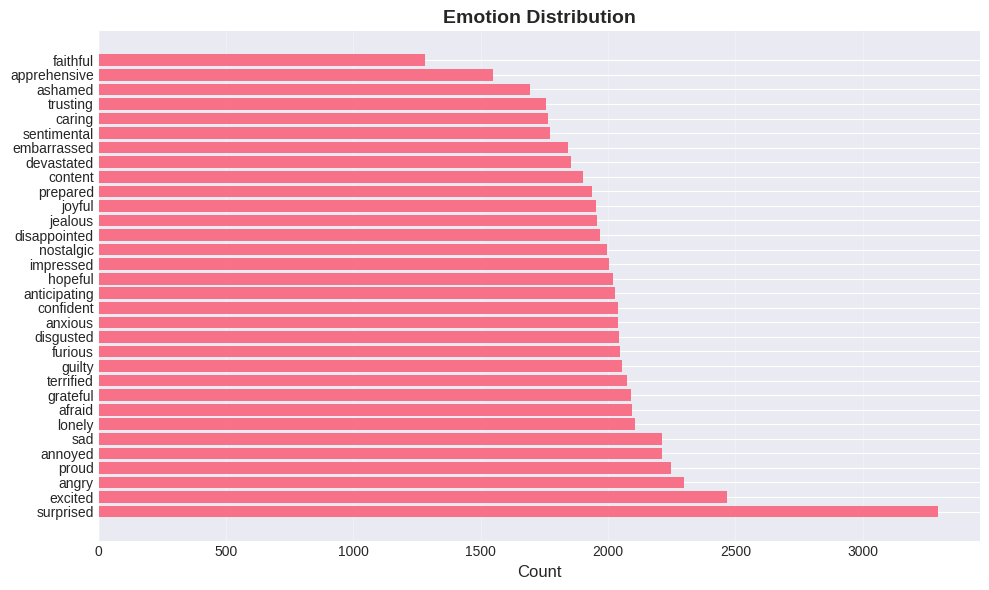

Data exploration plots saved as 'data_exploration.png'


In [9]:
# =====================================================================
# 3. VISUALIZE DATA DISTRIBUTION
# =====================================================================
print("\n[3] Creating Visualizations...")

fig, ax = plt.subplots(figsize=(10, 6))

# Plot: Emotion Distribution
emotion_counts = df_clean['emotion'].value_counts()

ax.barh(emotion_counts.index, emotion_counts.values)
ax.set_xlabel('Count', fontsize=12)
ax.set_title('Emotion Distribution', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('data_exploration.png', dpi=300, bbox_inches='tight')
plt.show()

print("Data exploration plots saved as 'data_exploration.png'")


In [10]:
df_clean.drop(columns=[col for col in df_clean.columns if "Unnamed" in col], inplace=True)

df_clean.head()

,Situation,emotion,empathetic_dialogues,labels,combined_text,emotion_encoded
0,I remember going to the fireworks with my best...,sentimental,Customer :I remember going to see the firework...,"Was this a friend you were in love with, or ju...",Situation: I remember going to the fireworks w...,28
1,I remember going to the fireworks with my best...,sentimental,Customer :This was a best friend. I miss her.\...,Where has she gone?,Situation: I remember going to the fireworks w...,28
2,I remember going to the fireworks with my best...,sentimental,Customer :We no longer talk.\nAgent :,Oh was this something that happened because of...,Situation: I remember going to the fireworks w...,28
3,I remember going to the fireworks with my best...,sentimental,Customer :Was this a friend you were in love w...,This was a best friend. I miss her.,Situation: I remember going to the fireworks w...,28
4,I remember going to the fireworks with my best...,sentimental,Customer :Where has she gone?\nAgent :,We no longer talk.,Situation: I remember going to the fireworks w...,28


In [15]:

# Split data: 70% train, 15% validation, 15% test
train_df, temp_df = train_test_split(
    df_clean, 
    test_size=0.3, 
    random_state=42, 
    stratify=df_clean['emotion_encoded']
)

val_df, test_df = train_test_split(
    temp_df, 
    test_size=0.5, 
    random_state=42, 
    stratify=temp_df['emotion_encoded']
)

print(f"\nTrain size: {len(train_df)}")
print(f"Validation size: {len(val_df)}")
print(f"Test size: {len(test_df)}")


Train size: 45213
Validation size: 9689
Test size: 9689


In [16]:
train_df.head()

,Situation,emotion,empathetic_dialogues,labels,combined_text,emotion_encoded
53693,Once I pulled into my drive way and saw that m...,devastated,Customer :Yes I did . But ignored my instincts...,I can. I'm so sorry. Was it something really b...,Situation: Once I pulled into my drive way and...,10
34954,I found my daughter sneaking on her computer l...,disappointed,Customer :that was probably us when we were li...,i know right,Situation: I found my daughter sneaking on her...,11
12715,"I'm going to see the show ""Kinky Boots"" on Bro...",excited,Customer :It's basically about a shoe manufact...,Sounds like a really heartwarming story. Hope ...,"Situation: I'm going to see the show ""Kinky Bo...",14
52896,"I really do not like pigs, they scare me.",afraid,"Customer :No, I do not even want to be within ...",That is how I feel about mice,"Situation: I really do not like pigs, they sca...",0
33575,I am still in awe that game of thrones is endi...,devastated,"Customer :I know what you mean, I love it so m...",daenarys of course,Situation: I am still in awe that game of thro...,10


In [17]:
# =====================================================================
# 5. CREATE PYTORCH DATASET
# =====================================================================
print("\n[5] Creating PyTorch Datasets...")

class EmotionDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts.iloc[idx])
        label = self.labels.iloc[idx]
        
        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }
# Initialize tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Create datasets
train_dataset = EmotionDataset(
    train_df['combined_text'].reset_index(drop=True),
    train_df['emotion_encoded'].reset_index(drop=True),
    tokenizer
)

val_dataset = EmotionDataset(
    val_df['combined_text'].reset_index(drop=True),
    val_df['emotion_encoded'].reset_index(drop=True),
    tokenizer
)

test_dataset = EmotionDataset(
    test_df['combined_text'].reset_index(drop=True),
    test_df['emotion_encoded'].reset_index(drop=True),
    tokenizer
)

# Create dataloaders
BATCH_SIZE = 16

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

print(f"Batch size: {BATCH_SIZE}")
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")


[5] Creating PyTorch Datasets...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Batch size: 16
Number of training batches: 2826
Number of validation batches: 606


In [18]:

# =====================================================================
# 6. INITIALIZE MODEL
# =====================================================================
print("\n[6] Initializing DistilBERT Model...")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

num_labels = len(label_encoder.classes_)
model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=num_labels
)
model = model.to(device)

# Optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

print(f"Number of emotion classes: {num_labels}")
print("Model initialized successfully!")



[6] Initializing DistilBERT Model...
Using device: cuda


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Number of emotion classes: 32
Model initialized successfully!


In [19]:
# 7. TRAINING FUNCTION
# =====================================================================
def train_epoch(model, dataloader, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    progress_bar = tqdm(dataloader, desc='Training')
    
    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        
        optimizer.zero_grad()
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        
        loss = outputs.loss
        logits = outputs.logits
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        predictions = torch.argmax(logits, dim=1)
        correct += (predictions == labels).sum().item()
        total += labels.size(0)
        
        progress_bar.set_postfix({'loss': loss.item(), 'acc': correct/total})
    
    return total_loss / len(dataloader), correct / total

In [20]:
# =====================================================================
# 8. EVALUATION FUNCTION
# =====================================================================
def evaluate(model, dataloader, device):
    model.eval()
    total_loss = 0
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc='Evaluating'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            
            loss = outputs.loss
            logits = outputs.logits
            
            total_loss += loss.item()
            
            predictions = torch.argmax(logits, dim=1)
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = accuracy_score(all_labels, all_predictions)
    
    return total_loss / len(dataloader), accuracy, all_predictions, all_labels

In [21]:
# =====================================================================
# 9. TRAIN MODEL
# =====================================================================
print("\n[7] Training Model...")

EPOCHS = 3
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

best_val_acc = 0

for epoch in range(EPOCHS):
    print(f"\n{'='*80}")
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print(f"{'='*80}")
    
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    
    # Validate
    val_loss, val_acc, _, _ = evaluate(model, val_loader, device)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    print(f"\nTrain Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pt')
        print(f"✓ Best model saved! (Val Acc: {val_acc:.4f})")

print("\n" + "="*80)
print("TRAINING COMPLETED!")


[7] Training Model...

Epoch 1/3


Evaluating: 100%|██████████| 606/606 [00:27<00:00, 22.10it/s]



Train Loss: 1.6040 | Train Acc: 0.5293
Val Loss: 1.0239 | Val Acc: 0.6637
✓ Best model saved! (Val Acc: 0.6637)

Epoch 2/3


Evaluating: 100%|██████████| 606/606 [00:28<00:00, 21.59it/s]



Train Loss: 0.7616 | Train Acc: 0.7510
Val Loss: 0.6621 | Val Acc: 0.7809
✓ Best model saved! (Val Acc: 0.7809)

Epoch 3/3


Evaluating: 100%|██████████| 606/606 [00:27<00:00, 22.01it/s]



Train Loss: 0.4271 | Train Acc: 0.8620
Val Loss: 0.4538 | Val Acc: 0.8654
✓ Best model saved! (Val Acc: 0.8654)

TRAINING COMPLETED!



[8] Plotting Training History...


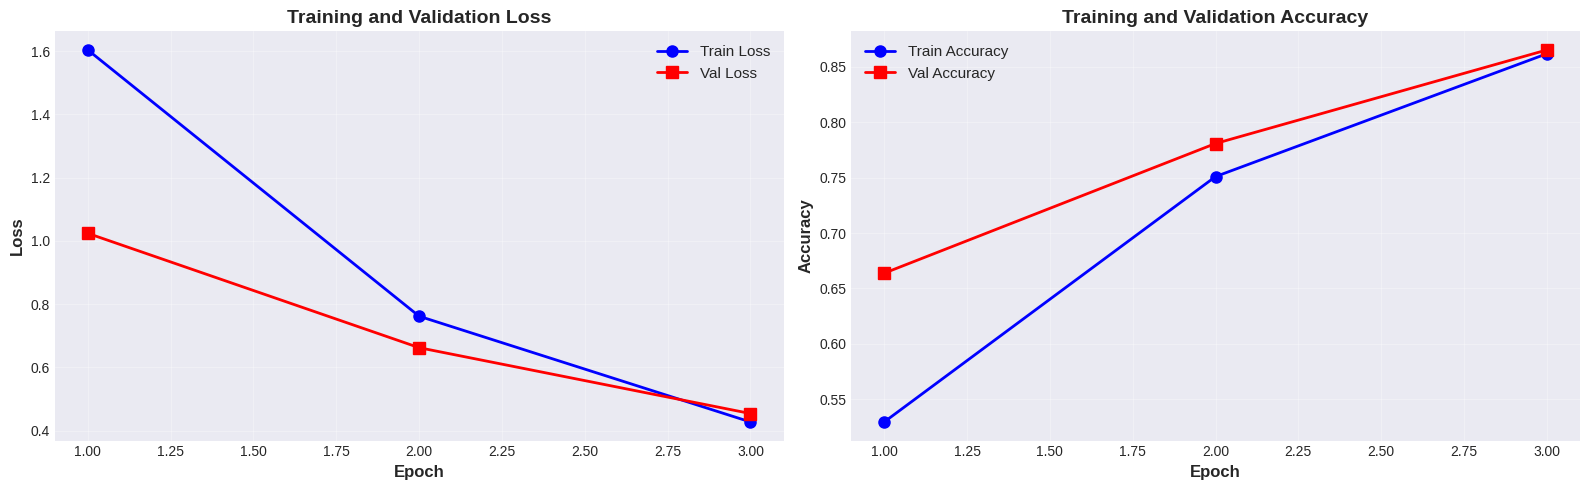

Training history saved as 'training_history.png'


In [22]:
# =====================================================================
# 10. PLOT TRAINING HISTORY
# =====================================================================
print("\n[8] Plotting Training History...")

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

epochs_range = range(1, EPOCHS + 1)

# Loss plot
axes[0].plot(epochs_range, train_losses, 'b-o', label='Train Loss', linewidth=2, markersize=8)
axes[0].plot(epochs_range, val_losses, 'r-s', label='Val Loss', linewidth=2, markersize=8)
axes[0].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Loss', fontsize=12, fontweight='bold')
axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Accuracy plot
axes[1].plot(epochs_range, train_accuracies, 'b-o', label='Train Accuracy', linewidth=2, markersize=8)
axes[1].plot(epochs_range, val_accuracies, 'r-s', label='Val Accuracy', linewidth=2, markersize=8)
axes[1].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Accuracy', fontsize=12, fontweight='bold')
axes[1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print("Training history saved as 'training_history.png'")

In [23]:
# =====================================================================
# 11. FINAL EVALUATION & CONFUSION MATRICES
# =====================================================================
print("\n[9] Final Evaluation...")

# Load best model
model.load_state_dict(torch.load('best_model.pt'))

# Evaluate on validation set
print("\nValidation Set Evaluation:")
val_loss, val_acc, val_preds, val_labels = evaluate(model, val_loader, device)
print(f"Validation Accuracy: {val_acc:.4f}")

# Evaluate on test set
print("\nTest Set Evaluation:")
test_loss, test_acc, test_preds, test_labels = evaluate(model, test_loader, device)
print(f"Test Accuracy: {test_acc:.4f}")


[9] Final Evaluation...

Validation Set Evaluation:


Evaluating: 100%|██████████| 606/606 [00:27<00:00, 21.92it/s]


Validation Accuracy: 0.8654

Test Set Evaluation:


Evaluating: 100%|██████████| 606/606 [00:27<00:00, 21.81it/s]

Test Accuracy: 0.8691



[10] Generating Confusion Matrices...


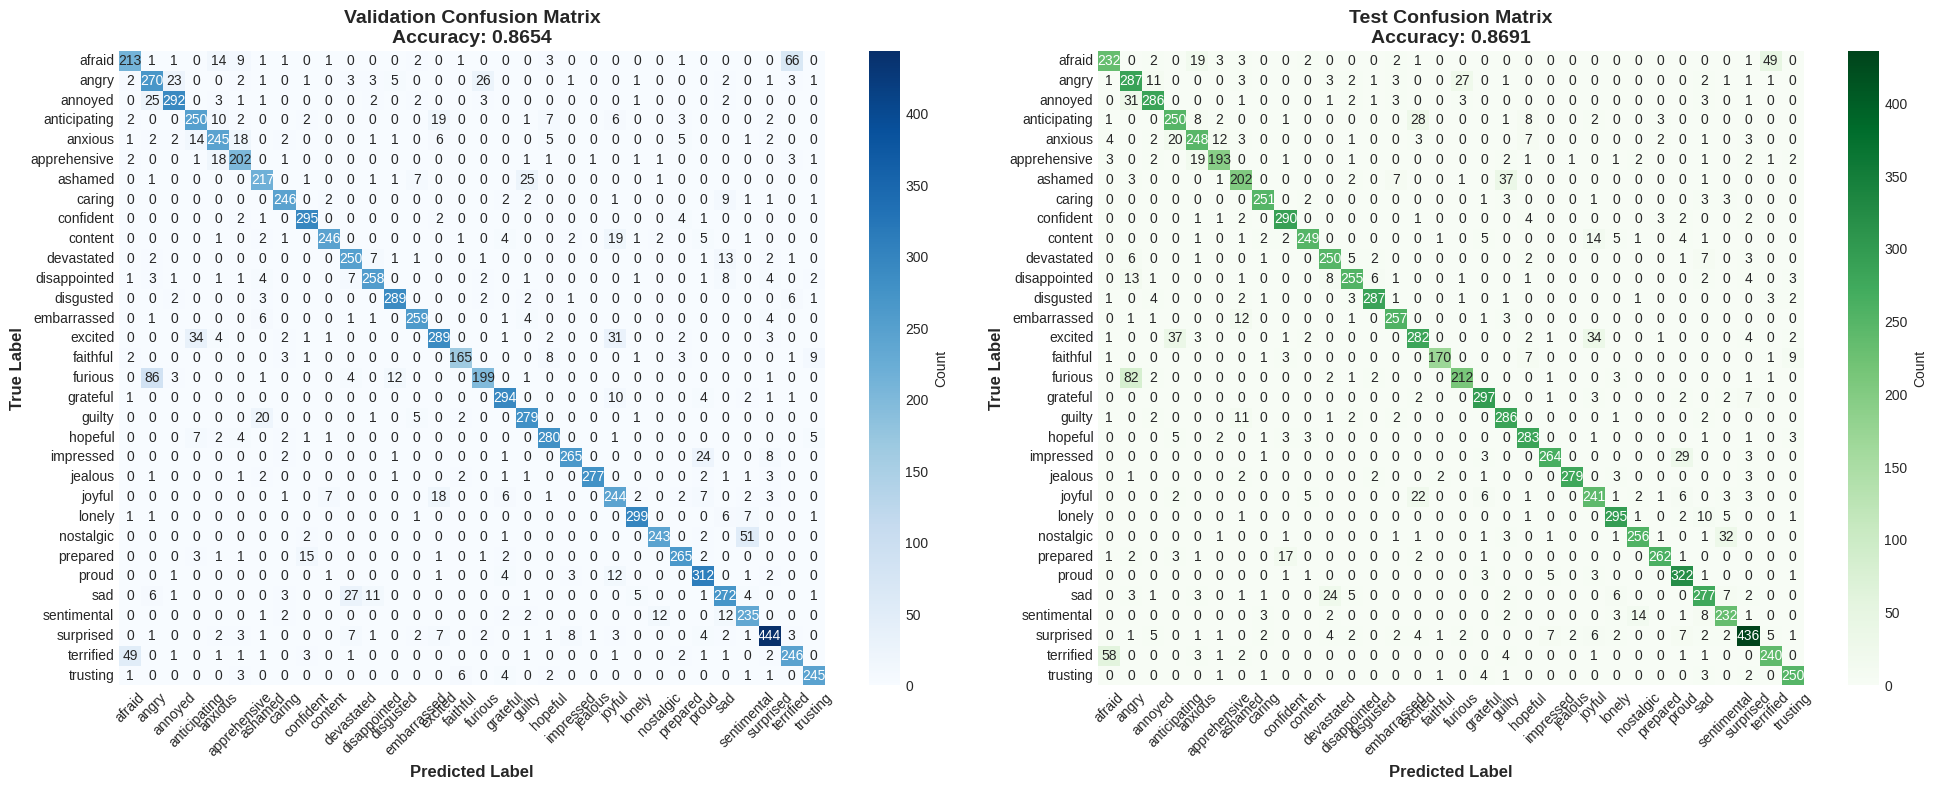

Confusion matrices saved as 'confusion_matrices.png'


In [24]:
# =====================================================================
# 12. CONFUSION MATRICES
# =====================================================================
print("\n[10] Generating Confusion Matrices...")

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Validation Confusion Matrix
cm_val = confusion_matrix(val_labels, val_preds)
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
            cbar_kws={'label': 'Count'})
axes[0].set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
axes[0].set_ylabel('True Label', fontsize=12, fontweight='bold')
axes[0].set_title(f'Validation Confusion Matrix\nAccuracy: {val_acc:.4f}', 
                  fontsize=14, fontweight='bold')
axes[0].tick_params(axis='x', rotation=45)
axes[0].tick_params(axis='y', rotation=0)

# Test Confusion Matrix
cm_test = confusion_matrix(test_labels, test_preds)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
            cbar_kws={'label': 'Count'})
axes[1].set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
axes[1].set_ylabel('True Label', fontsize=12, fontweight='bold')
axes[1].set_title(f'Test Confusion Matrix\nAccuracy: {test_acc:.4f}', 
                  fontsize=14, fontweight='bold')
axes[1].tick_params(axis='x', rotation=45)
axes[1].tick_params(axis='y', rotation=0)

plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

print("Confusion matrices saved as 'confusion_matrices.png'")

In [25]:
# =====================================================================
# 13. CLASSIFICATION REPORTS
# =====================================================================
print("\n" + "="*80)
print("VALIDATION SET CLASSIFICATION REPORT")
print("="*80)
print(classification_report(val_labels, val_preds, 
                          target_names=label_encoder.classes_,
                          digits=4))

print("\n" + "="*80)
print("TEST SET CLASSIFICATION REPORT")
print("="*80)
print(classification_report(test_labels, test_preds, 
                          target_names=label_encoder.classes_,
                          digits=4))


VALIDATION SET CLASSIFICATION REPORT
              precision    recall  f1-score   support

      afraid     0.7745    0.6783    0.7233       314
       angry     0.6750    0.7826    0.7248       345
     annoyed     0.8930    0.8795    0.8862       332
anticipating     0.8091    0.8224    0.8157       304
     anxious     0.8113    0.8033    0.8072       305
apprehensive     0.8080    0.8670    0.8364       233
     ashamed     0.8282    0.8543    0.8411       254
      caring     0.9248    0.9283    0.9266       265
   confident     0.9161    0.9672    0.9410       305
     content     0.9498    0.8632    0.9044       285
  devastated     0.8333    0.8961    0.8636       279
disappointed     0.9021    0.8746    0.8881       295
   disgusted     0.9293    0.9444    0.9368       306
 embarrassed     0.9283    0.9350    0.9317       277
     excited     0.8426    0.7811    0.8107       370
    faithful     0.9322    0.8549    0.8919       193
     furious     0.8432    0.6482    0.7330

In [26]:
# =====================================================================
# 14. SUMMARY STATISTICS
# =====================================================================
print("\n" + "="*80)
print("FINAL SUMMARY")
print("="*80)
print(f"Best Validation Accuracy: {best_val_acc:.4f}")
print(f"Final Test Accuracy: {test_acc:.4f}")
print(f"Total Emotions Classified: {num_labels}")
print(f"Total Training Samples: {len(train_df)}")
print(f"Total Validation Samples: {len(val_df)}")
print(f"Total Test Samples: {len(test_df)}")
print("="*80)

print("\n✓ All visualizations and models saved successfully!")
print("\nGenerated files:")
print("  - data_exploration.png")
print("  - training_history.png")
print("  - confusion_matrices.png")
print("  - best_model.pt")


FINAL SUMMARY
Best Validation Accuracy: 0.8654
Final Test Accuracy: 0.8691
Total Emotions Classified: 32
Total Training Samples: 45213
Total Validation Samples: 9689
Total Test Samples: 9689

✓ All visualizations and models saved successfully!

Generated files:
  - data_exploration.png
  - training_history.png
  - confusion_matrices.png
  - best_model.pt
